# Clustering avec mélanges de gaussiennes
Dans ce notebook nous travaillons sur un algorithme classique de clustering basé sur le modèle de mélange de gaussiennes.

## 1. Modèle de mélange gaussien

Soit $ \mu_{1},..., \mu_K \in \mathbb{R}^d$ et $\nu_1, ..., \nu_K \in ]0, \infty[$, où $K \geq 1$ est un entier qui correspond au nombre de clusters. Soit $Z$ un vecteur aléatoire gaussien variable aléatoire de loi $N(0,I_d)$ et soit $\xi$ une variable aléatoire à valeurs dans $\{1,...,K\}$ et indépendante de $Z$. On définit la variable aléatoire : 

$$
X= \mu_\xi + \sqrt{v_\xi} Z.
$$

On peut montrer que $X$ admet comme densité la fonction
$$
\sum_{k=1}^K p_k \phi_{\mu_k,v_k}(x)
$$
où $p_k = \mathbb P(\xi=k)$ et $\phi_{\mu,v}$ désigne la densité de la loi $N(\mu, v I_d)$.
On appelle cette densité une densité mélange de gaussiennes, car c'est une combinaison convexe de densités gaussiennes $\phi_{\mu_k, v_k}$.

**Question**

1. Simuler un $n$-échantillon de $X$. On prendra par exemple $n=500$, $K=3$, $d=2$, $p=(1/10, 1/2, 2/5)$, $\mu_1 = (0, 0)$, $\mu_2 = (-5, 5)$, $\mu_3 = (4, 3)$  et $v_1 = 1$, $v_2 = 1.5$ et $v3 = 2$. 
On ecrira une fonction qui prend en parametre $n, p, \mu$ et $v$, et qui renvoie un échantillon simulé selon ce modèle (on pourra utiliser la fonction de la loi multinomiale sur python).


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math
import seaborn as sns
%matplotlib inline

In [13]:
def create_samp(n, p, mu, xi): 
    Z = stats.norm.rvs(size=2*n, loc=0, scale=1)
    Z = np.reshape(Z, (-1,2))
    mu = np.array(mu).T
    
    xi =[math.sqrt(x) for x in xi]
    M = np.random.multinomial(1, p, n).T #(3,500)

    xi_k = np.reshape(np.dot(xi, M), (-1,1)) #(500,1)
    mu_k = np.dot(mu, M) #(500,2)
    X = mu_k.T + xi_k*Z
    
    cluster = np.dot(np.array([1,2,3]),M)
    return pd.DataFrame({'X1':X[:,0], 'X2':X[:,1], 'cluster': cluster})

In [14]:
X = create_samp(n=500, p=[1/10, 1/2, 2/5], mu=[(0,0), (-5,5), (4,3)], xi=[1,1.5, 2])

2. Représentez graphiquement ces données simulées avec un scatter plot.

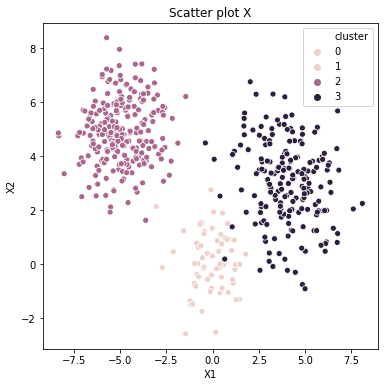

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(x='X1', y='X2', hue= 'cluster', data=X)
ax.set_title('Scatter plot X');

On connait ici le numéro de cluster de chaque point car a simulé les données.
Maintenant on veut retrouver en aveugle les numéros de cluster des points.
C'est à dire que, à partir de ce graphique : 

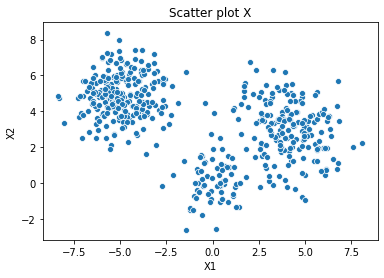

In [16]:
ax = sns.scatterplot(x='X1', y='X2', data=X)
ax.set_title('Scatter plot X');

...on veut retrouver les différents clusters.

Idée du soft assignment : 
Regardons avec K = 3 et d = 1
Les vecteurs deviennent : 

$\mu_1 = 0, \mu_2 = -5, \mu_3 = 4$ et on a toujours $v_1 = 1, v_2 = 1.5, v_3 = 2$ et $ p=(1/10,1/2,2/5)$ 


''

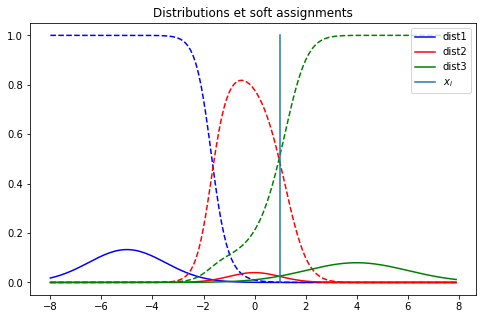

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(-8, 8, 0.1)
y1 = 1/10 * stats.norm.pdf(x, loc=0, scale=1)
y2 = 1/2 * stats.norm.pdf(x, loc=-5, scale=1.5)
y3 = 2/5 * stats.norm.pdf(x, loc=4, scale=2)
tmp = y1 + y2 + y3
ax.plot(x, y2, color = 'b', label = 'dist1')
ax.plot(x, y2/tmp, color = 'b', linestyle='dashed')
ax.plot(x, y1, color ='r', label='dist2')
ax.plot(x, y1/tmp, color = 'r', linestyle='dashed')
ax.plot(x, y3, color = 'g', label = 'dist3')
ax.plot(x, y3/tmp, color= 'g', linestyle='dashed')
ax.plot([1, 1], [0,1], linestyle = '-', label = '$x_i$')
ax.legend(loc="upper right")
ax.set_title('Distributions et soft assignments')
#ax.legend(['dist1', 'dist3', 'dist3'])
;

On a représentater les 3 distributions dans $ \mathbb{R} $. On fait apparaitre les responsibilities qui nous permettent d'affecter une des 3 classes à une nouvelle obs. $x_i$. Dans notre exemple, on affecte $x_i$ à la classe 2 (rouge).



### 2. Estimation avec l'algorithme EM (Expectation Maximization)

Dans le cas où les paramètres
$$
p=(p_1,p_2,\dots,p_K) \in [0, 1]^d, \quad \mu=(\mu_1,\mu_2,\dots,\mu_K) \in \mathbb R^{d\times K}, \quad v=(v_1,v_2,\dots,v_K) \in ]0, +\infty[^K
$$

sont inconnus et qu'on observe un échantillon $X_1,\dots,X_n$, on cherche à estimer les paramètres.
Il n'y a pas de solution explicite pour ces estimateurs.
La méthode classique pour cela est l'algorithme EM: il s'agit d'un algorithme itératif, qui cherche un maximiseur de la fonction de vraisemblance $L(p,\mu,v)$ dans ce modèle.
Dans le cas particulier considéré ici, on calcule à l'**étape E:**
$$ 
t_{ik}^{(r)} = \frac{p_k^{(r)} \phi_{\mu_k^{(r)},v_k^{(r)}}(X_i)}
{ \sum_{\ell=1}^K p_k^{(r)} \phi_{\mu_\ell^{(r)},v_\ell^{(r)}}(X_i)}
$$

et à l'**étape M**:
$$ 
p_k^{(r+1)}=\frac{1}{n} \sum_{i=1}^n t_{ik}^{(r)}, 
\quad \mu_k^{(r+1)}=\frac{\sum_{i=1}^n t_{ik}^{(r)} X_i}{\sum_{i=1}^n t_{ik}^{(r)}},
\quad
v_k^{(r+1)}=\frac{\sum_{i=1}^n t_{ik}^{(r)} \| X_i - \mu_k^{(r+1)}\|^2}
{d \sum_{i=1}^n t_{ik}^{(r)}}.
$$

On comprend l'algorithme assez facilement : $t_{ik}^{(r)}$ correspond à l'estimation à la $r$-ième itération de la probabilité que le point $i$ appartient au cluster $k$ (qu'on appelle "soft assignment"), alors que les autres formules correspondent à des estimations classiques de l'espérance et de la variance, mais pondérées par les soft assignments.

On procède de la façon suivante : on se donne des paramètres initiaux $(p^{(0)}, \mu^{(0)}, v^{(0)}) \in [0,1]^K \times \mathbb R^K \times ]0,\infty[^K$ tel que $\sum_{k=1}^K p^{(0)}_k = 1$, et on répète les itérations données par les étapes E et M, jusqu'à ce que la fonction de vraisemblance ne varie presque plus. 
En effet, une propriété remarquable de l'algorithme EM est qu'à chaque itération, la vraisemblance augmente:

$$
L(p^{(r+1)},\mu^{(r+1)},v^{(r+1)}) \ge L(p^{(r)},\mu^{(r)},v^{(r)}).
$$


Nous allons implémenter cet algorithme et visualiser son fonctionnement.

**Questions**

1. Ecrire une fonction qui calcule la log-vraisemblance du modèle, étant donné les données $X$ et les paramètres $p, \mu$ et $v$.

**Réponse**

La fonction de log-vraisemblance du modèle étant donné des données $X_1, \ldots, X_n$ i.i.d vaut

$$
\sum_{i=1}^n \log(\sum_{k=1}^K p_k \phi_{\mu_k, v_k}(X_i))
$$

On rappelle que la densité de la loi $N(\mu, v I_d)$ vaut 

$$
\phi_{\mu, v}(X_i) = \frac{1}{(2\pi v)^{d/2}} \exp(-\frac{(X_i-\mu)^t(X_i-\mu)}{2v})
$$

In [18]:
def normal_density(x, m, v, d):
    return math.exp(-sum(x - m)**2/2*v)/(2*math.pi*v)**(d/2)

In [19]:
def log_lik(X, probabilities, means, variances):
    '''
    1ère façon pas très élégante de le faire (2 boucles for)...
    '''
    n = len(X)
    K = len(means) #3
    d = 2
    L = 0
    tmp = 0
    for i in range(n):
        for k in range(K):
            tmp += probabilities[k]*normal_density(X.iloc[i,0:2], means[k], variances[k], d)
    L += math.log(tmp)
    return L


In [20]:
probabilities = [1/10, 1/2, 2/5]
means = np.array([(0,0), (-5,5), (4,3)])
variances = np.array([1,1.5, 2])

In [21]:
#Avec les vrais paramètres, la log-vrais. est maximale
log_lik(X, probabilities, means, variances)

2.473101954179513

En effet on observe ici que si on décale les paramètres, la vraisemblance devient plus petite

In [22]:
log_lik(X, probabilities, means+1, variances)

1.970311585650387

In [23]:
log_lik(X, probabilities, means, variances+10)

-0.4725163342373256

## 2. Ecrire une fonction qui calcule les soft-assignments (Etape E).

On utilise cette formule
$$ 
t_{ik}^{(r)} = \frac{p_k^{(r)} \phi_{\mu_k^{(r)},v_k^{(r)}}(X_i)}
{ \sum_{\ell=1}^K p_l^{(r)} \phi_{\mu_\ell^{(r)},v_\ell^{(r)}}(X_i)}
$$

In [24]:
def e_step(Xi, k, probabilities, means, variances):
    k += -1
    K = len(probabilities)
    tmp = [probabilities[l]*normal_density(Xi, means[l], variances[l], 2) for l in range(K)]
    return probabilities[k]*normal_density(Xi, means[k], variances[k], 2)/sum(tmp)

In [25]:
e_step(X.iloc[0,0:2],2, probabilities, means, variances)

0.735693174214146

In [44]:
soft_assignments = pd.DataFrame(
    {'t_1' : X.iloc[:,0:2].apply(lambda x: e_step(x, 1, probabilities, means, variances), axis=1),
     't_2' : X.iloc[:,0:2].apply(lambda x: e_step(x, 2, probabilities, means, variances), axis=1),
     't_3' : X.iloc[:,0:2].apply(lambda x: e_step(x, 3, probabilities, means, variances), axis=1)
    }
)
soft_assignments

,t_1,t_2,t_3
0,2.643068e-01,7.356932e-01,1.327702e-27
1,1.778607e-14,6.819177e-21,1.000000e+00
2,3.911232e-01,6.088768e-01,3.649724e-12
3,2.312856e-01,7.687144e-01,1.091040e-21
4,2.350621e-01,7.649379e-01,1.802432e-20
...,...,...,...
495,6.075461e-01,3.924539e-01,6.330938e-39
496,1.485502e-08,5.391866e-12,1.000000e+00
497,4.644345e-07,5.759072e-10,9.999995e-01
498,5.516536e-17,2.367866e-25,1.000000e+00


In [149]:
def entropy(p):
    return -sum(p*np.log(p))

''

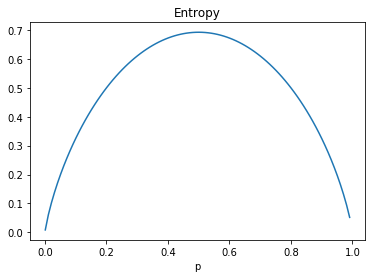

In [150]:
p = np.arange(0.001,1, 0.01)
fig, ax = plt.subplots()
ax.plot(p, entropy(np.array([p, 1-p])))
ax.set_title('Entropy')
ax.set_xlabel('p')
;

On comprend bien l'intérêt de la fonction entropie qui est maximale quand p=0.5. Elle permet de caractériser l'hétérogénéïté des groupes. Est-on proche d'une distribution uniforme ou non ? 

Si l'on revient à notre exemple, les individus ayant la plus forte entropie seront les individus les plus susceptibles d'être mal classés.

In [151]:
soft_assignments['entropie'] = soft_assignments.apply(lambda x : entropy(x), axis=1)

In [152]:
soft_assignments.head()

,t_1,t_2,t_3,entropie
0,2.643068e-01,7.356932e-01,1.327702e-27,8.945821e-01
1,1.778607e-14,6.819177e-21,1.000000e+00,1.694665e-11
2,3.911232e-01,6.088768e-01,3.649724e-12,9.380183e-01
3,2.312856e-01,7.687144e-01,1.091040e-21,8.732483e-01
4,2.350621e-01,7.649379e-01,1.802432e-20,8.759931e-01


In [153]:
#On affiche les 20 points les plus difficiles à classer
soft_assignments.sort_values('entropie', ascending=False).iloc[0:20,:]

,t_1,t_2,t_3,entropie
190,0.569851,0.035209,3.949400e-01,0.979659
83,0.611427,0.039257,3.493155e-01,0.977452
346,0.404986,0.021659,5.733549e-01,0.970726
201,0.359410,0.018444,6.221464e-01,0.961813
177,0.349419,0.017765,6.328159e-01,0.959288
69,0.328617,0.016380,6.550035e-01,0.953235
42,0.322178,0.015958,6.618631e-01,0.951122
401,0.507125,0.492875,1.429338e-09,0.947157
487,0.492827,0.507173,7.506230e-10,0.947157
333,0.491889,0.508111,7.190890e-10,0.947146


In [154]:
#on récupère leur index pour pouvoir les afficher sur un graph
idx = soft_assignments.sort_values('entropie', ascending=False).iloc[0:20,:].index
idx = list(idx)

''

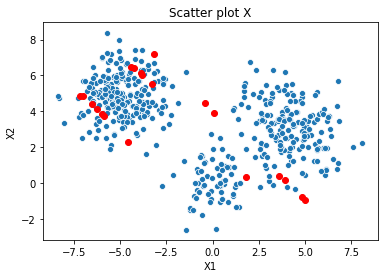

In [155]:
ax = sns.scatterplot(x='X1', y='X2', data=X)
ax.set_title('Scatter plot X')
plt.scatter(x=X.iloc[idx, 0], y=X.iloc[idx, 1], color='r')
;

## 3. Ecrire une fonction qui applique l'étape M, en utilisant les formules données au dessus.

**Réponse**

On applique les formules d'au dessus, où on multiplie au numérateur et dénominateur $1/n$:

$$ 
p_k^{(r+1)}=\frac{1}{n} \sum_{i=1}^n t_{ik}^{(r)}, 
\quad \mu_k^{(r+1)} = \frac{\frac 1n \sum_{i=1}^n t_{ik}^{(r)} X_i}{\frac 1n  \sum_{i=1}^n t_{ik}^{(r)}},
\quad
v_k^{(r+1)}=\frac{\frac 1n \sum_{i=1}^n t_{ik}^{(r)} \| X_i - \mu_k^{(r+1)}\|^2}
{\frac dn \sum_{i=1}^n t_{ik}^{(r)}}
$$


qu'on peut donc réecrire sous la forme

$$ 
p_k^{(r+1)}=\frac{1}{n} \sum_{i=1}^n t_{ik}^{(r)}, 
\quad \mu_k^{(r+1)} = \frac{\frac 1n \sum_{i=1}^n t_{ik}^{(r)} X_i}{p_k^{(r+1)}},
\quad
v_k^{(r+1)}=\frac{\frac 1n \sum_{i=1}^n t_{ik}^{(r)} \| X_i - \mu_k^{(r+1)}\|^2}
{d p_k^{(r+1)}}
$$

**Remarque.** L'exposant $p_k^{(r)}$ indique le fait qu'on utilise la valeur du paramètre $p_k$ à l'itération $r$ de l'algorithme EM.
Cet indice n'a pas d'utilité  quand on implémente l'algorithme. On ne va pas stocker toutes les valeurs des paramètres pour toutes les itérations $r = 1, 2, \ldots,$. On ne va conserver que les valeurs les plus récentes


In [285]:
def m_step(X, soft_assignments, K):
    dic = {'p_k':[], 'mu_k':[], 'v_k':[]}
    d = X.shape[1]
    for k in range(K): #3
        dic['p_k'].append(np.mean(soft_assignments.iloc[:,k]))
        tmp = pd.concat([soft_assignments.iloc[:,k], soft_assignments.iloc[:,k]], axis=1)
        dic['mu_k'].append(tuple(np.mean(np.array(tmp)*np.array(X.iloc[:,0:2]), axis=0)/dic['p_k'][k]))
        #calcul des variances
        X_minus_mu = (np.array(X.iloc[:,0:2]) - dic['mu_k'][k])**2
        X_minus_mu = pd.DataFrame(X_minus_mu, columns=['x1','x2'])
        dist = X_minus_mu.apply(sum, axis=1)
        dist = np.array(dist)
        variance_num = np.mean(np.array(soft_assignments.iloc[:,k])*dist, axis=0)
        dic['v_k'].append(variance_num/(dic['p_k'][k]*d)) #/(dic['p_k'][k]*d)
    return dic

In [286]:
m_step(X, soft_assignments, 3)

{'p_k': [0.25318076592340477, 0.3874730218416492, 0.3593462122349458],
 'mu_k': [(-3.44188785507732, 3.6407373184813436),
  (-3.720930348290861, 3.754709273071684),
  (4.106368228157767, 3.2077749052083004)],
 'v_k': [4.907877103301421, 3.6509788023406595, 1.4427225461674174]}

Mettre en oeuvre l'algorithme en utilisant les fonctions définies au dessus: on fera une 
boucle `for` qui effectue 100 itérations, et qui calcule à chaque étape la valeur de la 
vraisemblance après application des étapes E et M. 
On initialisera $(p^{(0)},\mu^{(0)},v^{(0)})$ au hasard (en faisant attention de simuler $p$ dans le simplexe, en utilisant par exemple une loi de Dirichlet). 
Représentez l'évolution de la fonction de vraisemblance le long des itérations (cela devrait donc être croissant...)


In [347]:
#initialisation des paramètres
p_0 = [0.1, 0.2, 0.8]; mu_0 = [(0,2),(0,4),(4,0)]; v_0 = [1,2,1] 
probabilities = p_0; means = mu_0; variances = v_0

def softKmeans(X, probabilities, means, variances):
    K = len(probabilities)
    X = X.iloc[:,0:2] 
    for i in range(50):
        soft_assignments = pd.DataFrame()
        #E-step
        for k in range(K):
            soft_assignments['t_'+str(k+1)] = X.apply(lambda x: e_step(x, k, probabilities, means, variances), axis=1)
        cluster = np.array(soft_assignments).argmax(axis=1) + 1
        cluster = pd.DataFrame({'cluster':cluster})
        #M-step
        dic = m_step(X, soft_assignments, K)
        if(i%10==0):
            print(log_lik(X, dic['p_k'], dic['mu_k'], dic['v_k']))
            #Pour visualiser la convergence
                #df = pd.concat([X,cluster], axis=1)
                #fig, ax = plt.subplots(figsize=(6,6))
                #ax = sns.scatterplot(x='X1', y='X2', hue= 'cluster', data=df)
        probabilities = dic['p_k']; means=dic['mu_k']; variances= dic['v_k'];


In [348]:
softKmeans(X=X, probabilities=p_0, means= mu_0, variances=v_0)

0.4393121066900113
1.0421334530960915
1.039007158902704
1.0389459404065577
1.0389454786237278


## 5. Visualisation de la convergence 

Visualiser les itérations de l'algorithme EM en faisant un scatter plot après chaque itérations (ou toutes les 10 itérations) par exemple. Conclure.

In [346]:
#On modifie juste la fonction softKeans de façon à afficher un scatterplot à chaque itération

def softKmeans(X, probabilities, means, variances):
    K = len(probabilities)
    X = X.iloc[:,0:2] 
    for i in range(50):
        soft_assignments = pd.DataFrame()
        #E-step
        for k in range(K):
            soft_assignments['t_'+str(k+1)] = X.apply(lambda x: e_step(x, k, probabilities, means, variances), axis=1)
        cluster = np.array(soft_assignments).argmax(axis=1) + 1
        cluster = pd.DataFrame({'cluster':cluster})
        #M-step
        dic = m_step(X, soft_assignments, K)
        if(i%10==0):
            print(log_lik(X, dic['p_k'], dic['mu_k'], dic['v_k']))
            #Pour visualiser la convergence
            df = pd.concat([X,cluster], axis=1)
            fig, ax = plt.subplots(figsize=(6,6))
            ax = sns.scatterplot(x='X1', y='X2', hue= 'cluster', data=df)
        probabilities = dic['p_k']; means=dic['mu_k']; variances= dic['v_k'];

In [ ]:
softKmeans(X=X, probabilities=p_0, means= mu_0, variances=v_0)

Au fur et à mesure des itérations l'aglorithme performe de mieux en mieux.